# Ingest Content

## Dependencies

Install the following dependencies first:

In [ ]:
!pip install bs4 jsonlines

## Find all internal URLs

First step is to crawl a domain for all internal links leading to HTML content. Do this until everything is discovered. Enter your domain through adjusting the `url` in `__main__`.

Write the set of discovered URLs from `all_links` to disk, converting them to `jsonl` format for easier processing in the next steps. We'll build upon that `page` dict in the following steps.

In [1]:
import requests
import jsonlines
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
 
def get_domain(url):
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain
 
def get_links(url, response):
    if (response.ok): 
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for link in soup.find_all('a'):
            link_url = link.get('href')
            if link_url:
                absolute_link = urljoin(url, link_url)
                if absolute_link.startswith(domain):
                    links.add(absolute_link)
        return links
    return [] 

def mapLink(url):
    page = dict()
    page['url'] = url
    return page 
 
if __name__ == '__main__':
    url = 'https://www.taktsoft.com'
    domain = get_domain(url)
    queue = [url]
    visited = set()
    all_links = set()
 
    while queue:
        url = queue.pop(0)
        visited.add(url)
        response = requests.get(url)
        if (response.ok and "text/html" in response.headers['Content-Type']):
            print(url)
            if (url.rstrip("/") not in all_links):
                all_links.add(url.rstrip("/"))
    
            links = get_links(url, response)
            for link in links:
                if link not in visited and link not in queue and '#' not in link and '?' not in link:
                    queue.append(link)
        
    print('All done! ' + str(len(all_links)) + ' links discovered.')

    pages = map(mapLink, all_links)

    with jsonlines.open('pages.jsonl', 'w') as writer:
        writer.write_all(pages)

https://www.taktsoft.com
https://www.taktsoft.com/campus/konzept
https://www.taktsoft.com/technical-debt
https://www.taktsoft.com/software-develoment-waste
https://www.taktsoft.com/digital-commerce
https://www.taktsoft.com/campus/podcast/episoden
https://www.taktsoft.com/case-study/swo
https://www.taktsoft.com/digitale-produkte
https://www.taktsoft.com/tech-stacks/scrivito
https://www.taktsoft.com/grafana
https://www.taktsoft.com/agile/scrum-prozess
https://www.taktsoft.com/case-study/badenova
https://www.taktsoft.com/energiewirtschaft/sw-web
https://www.taktsoft.com/campus/mieten/podcast_lounge
https://www.taktsoft.com/
https://www.taktsoft.com/campus/newsletter
https://www.taktsoft.com/partner
https://www.taktsoft.com/jobs/praktikum-praxissemester-softwareentwicklung
https://www.taktsoft.com/impressum
https://www.taktsoft.com/agile
https://www.taktsoft.com/campus/themen
https://www.taktsoft.com/big-blue-button
https://www.taktsoft.com/wie-wir-denken
https://www.taktsoft.com/agile/kon

## More dependencies

Install trafilatura, that will be used to extract the content from pages, and tiktoken to have a first relevant token measurement for complete page content.

In [ ]:
!pip install trafilatura tiktoken

## Extract content from discovered pages

We'll keep Markdown formatting for now. It will be used to split sections from pages by slicing by headlines. 

In [2]:
import re
import jsonlines
import tiktoken
from bs4 import BeautifulSoup
from trafilatura import fetch_url, extract
from markdown import markdown

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

extracted_content = []
with jsonlines.open('pages.jsonl') as pages:
    for page in pages:
        downloaded = fetch_url(page['url'])
        parsed = BeautifulSoup(downloaded)
        ogTitle = parsed.find("meta", property="og:title")
        title = parsed.title.string if parsed.title.string else ogTitle["content"] if ogTitle else page['url']
        result = extract(downloaded, url=page['url'], include_formatting=True)

        if result is None:
            print('couldnt extract:', page['url'])
        else:
            augmented = dict()
            augmented['url'] = page['url']
            
            augmented['content'] = dict()
            augmented['content']['raw'] = markdown_to_text(result)
            augmented['content']['markdown'] = result
            augmented['lines'] = result.splitlines()
            augmented['title'] = title
            augmented['size'] = len(result)
            augmented['token'] = len(enc.encode(result))
            extracted_content.append(augmented)
            print('extracted:', augmented['url'], augmented['title'], str(augmented['token']) + ' Token,', len(result))  

with jsonlines.open('pages_extracted.jsonl', 'w') as pages:
    pages.write_all(extracted_content)
    
print('wrote extracted content to "pages_extracted.jsonl"')

extracted: https://www.taktsoft.com/campus/konzept Das offene Konzept des Taktsoft Campus: Meetups, Austausch, Vielfalt 1141 Token, 3202
extracted: https://www.taktsoft.com/koepfe Taktsoft Bonn - Köpfe 688 Token, 1858
extracted: https://www.taktsoft.com/technical-debt Technical Debt 932 Token, 2618
extracted: https://www.taktsoft.com/software-develoment-waste Software Development Waste 978 Token, 2712
extracted: https://www.taktsoft.com/digital-commerce Digital Commerce 735 Token, 2089
extracted: https://www.taktsoft.com/campus/podcast/episoden Taktsoft Campus Podcast Episoden 8609 Token, 23464
extracted: https://www.taktsoft.com/case-study/swo Case Study Website Stadtwerke Osnabrück 745 Token, 2041
extracted: https://www.taktsoft.com/digitale-produkte Digitale Produktentwicklung 773 Token, 2165
extracted: https://www.taktsoft.com/tech-stacks/scrivito Scrivito CMS 994 Token, 2742
extracted: https://www.taktsoft.com/grafana Grafana - Plattformübergreifende Datenvisualisierung 400 Token,

## Even more dependencies

Install the BERT extractive summarizer and Sentence Transformers, we'll use these to create summaries as a first step.

In [ ]:
!pip install bert-extractive-summarizer sentence-transformers

## Create SBert summaries

We first create SBert summaries by identifying the most central sentences on a page, concatenating those for a rough first summary.

In [3]:
import tiktoken
from summarizer.sbert import SBertSummarizer

enc = tiktoken.encoding_for_model("text-davinci-003")
model = SBertSummarizer('paraphrase-multilingual-MiniLM-L12-v2')  

extracted_content = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        result = model(page['content']['raw'], num_sentences=5, min_length=60)
        full = ''.join(result)
        print(page['url'], page['title'], str(len(enc.encode(full))) + ' Token,', full)

/home/julrich/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-05 21:37:24.660558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 21:37:24.747460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-05 21:37:24.747475: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on you

https://www.taktsoft.com/campus/konzept Das offene Konzept des Taktsoft Campus: Meetups, Austausch, Vielfalt 328 Token, Das offene Konzept des Taktsoft Campus: Meetups, Austausch, Vielfalt
Gesucht: T-Shape-Entwickler und Helicopter-Shape-People
Zeitgemäße, interdisziplinäre Teams brauchen Menschen mit breiter fachlicher Qualifikation
Wir wollen Software-Professionals mehr Verantwortung und bessere Ergebnisse ermöglichen, indem wir ein breites Themen-Spektrum erschließen. tritt der Ansatz von Business-Teams, die so zusammengesetzt sind, dass sie autark Wertschöpfung und Business-Ziele erreichen können oder für bestimmte Services vollumfänglich verantwortlich sind. So, als hätte ein erfahrener Kollege*in Ihnen das vermittelt. Daher ist der Taktsoft Campus ein offenes Konzept mit dedizierten Räumen, Platz für Begegnung und einem Programm von offenen Seminaren und Veranstaltungen. Durch die Verbindung zu Taktsoft sind die Themen im Campus von den täglichen Herausforderungen einer Softwaree

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/campus/podcast/episoden Taktsoft Campus Podcast Episoden 424 Token, Taktsoft Campus Podcast
Alle Episoden
Wenn Ihr Themen habt, die Ihr gern in einem Podcast beleuchtet haben möchtet, sendet eine Email an
podcast@taktsoft.com. In diesem Podcast rede ich mit
Michael Kornobis, Lead Consultant Tracking & Analytics bei fusedeck GmbH. Michael blickt auf über 10 Jahre Erfahrung im Bereich AdTech und MarTech bei renommierten Firmen wie ProSiebenSat.1 Media, Quantcast Deutschland und intelliAd Media zurück. Folge 19 - Praktische Einführung in die Websecurity – Teil 2
Wie die Quellcode-Analyse hilft
Im Podcast Folge 6 „eine praktische Einführung in die Websecurity“ sprach ich mit
Ben Fuhrmannek, einem passionierten Websicherheits-Experten und Geschäftsführer der Sektioneins GmbH. (www.sektioneins.de)
Ben erläuterte Themen wie Angriffsarten und potenzielle Schwachstellen. Folge 17 - Danke an die Taktsoft Podcast Community
und ein Paar Fragen
Wir haben in den vergangenen 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.taktsoft.com/agile/scrum-prozess Der Scrum Prozess 279 Token, Der Scrum Prozess
Um mit Scrum Software zu entwickeln ist es für das Projektteam entscheidend die Intention dahinter zu begreifen und entsprechend zu handeln. - Ereignisse im Scrum Prozess
- Ergebnisse (Artefakte) im Scrum Prozess
- Beteiligte am Scrum Prozess
- Tranzparenz der Artefakte im Scrum Prozess
Scrum gibt Orientierung, doch lässt vieles offen. Bei Taktsoft haben wir einige Aspekte noch enger gefasst und machen über Scrum hinaus Vorgaben, die Teil unseres Agilen Prozesses sind. Das Ergebnis des Sprint Plannings wird vom gesamten Scrum Team verabschiedet und ist die Grundlage für den anstehenden Sprint. Zusätzlich zum Feature-Wunsch (und eigentlichen Story) gehören zu einer User Story grundsätzlich Akzeptanzkriterien.
https://www.taktsoft.com/case-study/badenova Case Study badenova White Label Ecommerce Plattform 289 Token, badenova White Label E-Commerce Plattform
Für die badenova haben wir eine hoch-per

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/campus/lehrgang-scrum-master Zertifizierung Professional Scrum Master 249 Token, Professional Scrum Master
Welche Themen werden während des Trainings behandelt? Wasserfall und agil im Vergleich
- Agile Werte und Prinzipien
- Das Scrum-Framework: Rollen, Events und Artefakte
- Die Rolle des Scrum Masters
- Product Backlog Management und Stakeholder-Management
- Team-Entwicklung und Servant Leadership
- Fragen & Antworten (Q&A session)
Wie ist das Training aufgebaut? - Sie erhalten einen kostenlosen Zweitversuch für die Zertifizierungsprüfung, sollten Sie diese binnen 14 Tagen nicht bestehen. Gregor Stuhldreier ist Professional Scrum Trainer (PST) der Scrum.org. Die Begleitung großer agiler Transformationen in mittelständischen als auch in weltweit agierenden DAX-Konzernen runden sein Profil ab.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/energiewirtschaft/sw-web SW-web: Die Lösung für Stadtwerke Websites 489 Token, Stadtwerke im Web sichtbar, spürbar und erlebbar machen
Mit SW-web, der smarten Weblösung für Stadtwerke
SW-web: Die Lösung für Stadtwerke Websites
Was macht eine gute Stadtwerke Website aus? Es gilt einen Überblick über verschiedenen Themen zu geben und diese Themen miteinander zu verzahnen, z.B.:
Mobilität
Ladelösungen
Photovoltaik
Stromspeicher
Energie sparen
Neben Energie, Strom, Gas, Wärme und Wasser, haben viele Stadtwerke weitere Bereiche, seien es Bäder, ÖPNV oder andere öffentliche Einrichtungen. Daher ist es überlebenswichtig, Kunden bereits hier und heute digitale Interaktionsmöglichkeiten zu bieten, auch wenn man noch ein Stück von voll integrierten Wertschöpfungsketten entfernt ist. Eine starke Marke dagegen fällt nicht nur auf, sondern gewinnt auch das Vertrauen der Kunden. Features von SW-web

Redakteursfreundliches Inline Editing (WSIWYG)
Erweiterbare Medienverwaltung

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/campus/mieten/podcast_lounge Taktsoft Campus Podcast Lounge 501 Token, Mieten Sie den Raum in Bonn für Videokonferenzen, Webkonferenzen und Podcast-Aufnahmen
Die Podcast Lounge

Unsere Podcast-Lounge steht Ihnen bereit für
professionelle Aufnahmenvon Podcastsund Audiomedien. fußläufig vom
HauptbahnhofLocation Studiotag: 250,- € Netto, Halber Studiotag140,- € Netto
Genaue Informationen zu den Preisen: hier

So können Sie die Podcast Lounge nutzen
Der Raum und seine technische Ausstattung
Es stehen Ihnen 2 Sprecher/Aufnahmenplätze an zwei gegenüberliegenden Tischen und 1 Technik-Platz an einem separaten Schreibtisch zur Verfügung. Audio-Technik

1x Universal Audio Apollo Twin MKII Duo Heritage Audio Interface
2x Shure SM 7B Studiomikro
1x beyerdynamic DT-770 PRO Studiokopfhörer
1x the t.bone SC 440 USB Kondensator-Mikrofon mit Popkiller auf Stativ
(als Alternative zu den Shure Mikrofonen zum direkten Betrieb am Computer)
1x Zoom H1n MP3 / Wave Handyrecorder
Die S

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.taktsoft.com/agile Agile Softwareentwicklung 222 Token, Agile Softwareentwicklung
Was ein Agile Delivery Mindset ausmacht
Agilität beginnt im Kopf. Priorisierung) wie der größtmögliche Wert (Business Value) durch Software erreicht werden kann. Im Rahmen dieser Konzeption wird geklärt was getan werden soll, wie dieses wann und wie zeitnah umgesetzt wird. - Die regelmäßige Bewertung der durch das oder die Teams erzielten Ergebnisse, um Anpassungen der nächsten Schritte / der Planung vornehmen zu können. Dabei ist Scrum die Quelle für viele der Denkansätze hinter dem Agilen Manifest und zugleich ist das Agile Manifest die Basis für einen Prozess nach Scrum.
https://www.taktsoft.com Taktsoft: Implementierung digitaler Geschäftsmodelle 236 Token, Wir setzen die Ideen unserer Kunden für digitale Geschäftsmodelle technologie-getrieben um
Digitalisierung heißt, die passende Software zu entwickeln
Wir liefern die technische Lösung zu den Ideen unserer Kunden, um digitale Geschäftsmo

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/agile/konzeption Wie man agile Projekte konzipiert 380 Token, Wie man agile Projekte konzipiert
Ziele der Konzeption in agilen Projekten
Konzeption und Planung agiler Projekte heißt für uns alles was zur Vorbereitung eines Sprints notwendig ist, was also vor einem Sprint Planning geschehen muss. Wichtigstes Ziel der Konzeption- und Planungsphase / der Feinkonzeption vor dem Beginn der Entwicklung ist die Erstellung eines Backlogs als Input für die ersten Sprints. Der Anspruch ist erstens ein ausreichend ausführliches Backlog zu haben, um mit der Entwicklung starten zu können und zweitens den Gesamtumfang der Software in dem Maße beschrieben / umrissen zu haben, um das Funding der Projektumsetzung sicherstellen zu können. Das Backlog muss also die Frage beantworten was zu tun ist und wie wichtig einzelne Bestandteile / Aufgaben, also Product Backlog Items sind. Ein gemeinsames Vertändnis aufbauen
Neben dem Aufbau des Produkt-Backlogs als greifbarem Resultat ist 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.taktsoft.com/datenschutz Datenschutz 374 Token, Datenschutz
Name und Kontakt des Verantwortlichen gemäß Artikel 4 Abs. Nähere Informationen hierzu erhalten Sie bei Angabe Ihrer personenbezogenen Daten oder untenstehend in der Beschreibung des Angebotes. Der Verantwortliche verarbeitet die personenbezogenen Daten nicht mehr, es sei denn, er kann zwingende schutzwürdige Gründe für die Verarbeitung nachweisen, die die Interessen, Rechte und Freiheiten der betroffenen Person überwiegen, oder die Verarbeitung dient der Geltendmachung, Ausübung oder Verteidigung von Rechtsansprüchen. (3) Sie können die Speicherung der Cookies durch eine entsprechende Einstellung Ihrer Browser-Software verhindern; wir weisen Sie jedoch darauf hin, dass Sie in diesem Fall gegebenenfalls nicht sämtliche Funktionen dieser Website vollumfänglich werden nutzen können. Ihrer IP-Adresse) an Google sowie die Verarbeitung dieser Daten durch Google verhindern, indem sie das unter dem folgenden Link verfügba

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/solidus Solidus Ecommerce Plattform 340 Token, Solidus Ecommerce Plattform
B2B-E-Commerce mit dem Solidus Ecommerce-System
Der B2B-Vertrieb über Online-Shops steht bei einem Großteil des Mittelstandes noch am Anfang. Während das eine E-Commerce System eher mit Funktionen überfrachtet auf vielseitige Konzernanspüche der Industrie zielt, bieten andere Systeme eventuell zu wenig Funktionen für diese Branchen an. Das System ist programmiertechnisch äußerst anpassbar und modifizierbar - konzipiert als „Profi-Software für Profi-Anwender“ und „von Entwicklern für Entwickler“. Bezeichnende Einsatzmöglichkeiten von Solidus im B2B-E-Commerce sind das Kerngeschäft Digitalprodukte (Software, elektronische Produktkataloge, Dokumente) oder das Servicegeschäft Komponentenzulieferung - Ersatzteilgeschäft des Maschinen- und Fahrzeugbau. Ecommerce für Digitale Produkte und Digitale Dienste
Sie bieten im Kerngeschäft Digitale Produkte zum Erwerb per Download an?


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/devops/tools DevOps Tools, Prozesse & Infrastruktur 231 Token, DevOps Tools, Prozesse & Infrastruktur
DevOps
Die Kombination aus Development und Operations ist bei Taktsoft selbstverständlich. Diese zielgerichtet und vor allem reproduzierbar zum Einsatz zu bringen, wird durch Automatisierung an vielen Stellen stark vereinfacht und zum Teil sogar erst möglich gemacht. Nach Absprache mit unseren Kunden sind wir durchaus gerne bereit, dieses Vorgehen auf die Produktions-Umgebung auszudehnen. Sicherheit
Die Sicherheit der von uns betriebenen Software, insbesondere der Daten, genießt bei uns einen hohen Stellenwert. Also gilt es möglichst, Probleme festzustellen und darauf zu reagieren, bevor Nutzer sie bemerken.
https://www.taktsoft.com/campus/seminare Seminare 167 Token, Seminare
Veranstaltungen Filtern
3 Veranstaltungen
Was ist ein Design System und welchen Wert bringt es meinem Unternehmen? Jonas Ulrich hat als CTO von kickstartDS ein digitales Design System als

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.taktsoft.com/campus Zielgerichtete Weiterbildung für Softwareentwickler, Projektverantwortliche und Digital-Spezialisten 306 Token, Zielgerichtete Weiterbildung für Softwareentwickler, Projektverantwortliche und Digital-Spezialisten
Der Campus – Ein Forum für Professionals
Wissen für Software-Professionals
Sich Austauschen, gemeinsam Lernen, neues Wissen erschliessen und die eigenen Fähigkeiten ausbauen
Unser sehr persönlicher Ansatz
Es gibt reichlich Informationen und Softwarewissen im Web. Sie gehen auf Teilnehmer ein, geben Orientierung, zielgerichtete Hinweise und Tipps, um aus jedem unserer Lernangebote substantiell etwas mitzunehmen. Nicole Konegen
Webentwicklerin
Radikant GmbH
Den Campus mieten
Die Räume des Campus für Tagungen, Konferenzen, Meetings oder Seminare mieten
Sie möchten den Taktsoft Campus als Raum für ihr eigenes Meeting mieten? Der Taktsoft Campus liegt direkt im Zentrum der Bundessstadt Bonn. Hör dir unseren Podcast an, lass sich per E-Mail informiere

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/jobs/softwareentwicklung-ruby-on-rails Stellenanzeige Softwareentwicklung Ruby on Rails in Vollzeit bei Taktsoft in Bonn (w/m/x) 229 Token, Stellenanzeige Softwareentwicklung Ruby on Rails in Vollzeit bei Taktsoft in Bonn (w/m/x)
Wir entwickeln nachhaltige Software und suchen dafür nachhaltige Verstärkung. Du bewegst dich dabei gerne im Open-Source-Umfeld und auf der Kommandozeile? Taktsoft ist ein Softwarehaus, das mit Hilfe aktueller Technologien und Prozessen, nachhaltige Individual-Software für verschiedene Kunden entwickelt und betreibt. Wir begleiten unsere Kunden von der Produktidee über das erste Produktionsrelease bis hin zum Betrieb über Jahre. Unser Stellenangebot gilt für einen Ruby on Rails Softwareentwickler oder eine Softwareentwicklerin zum nächst möglichen Zeitpunkt.
https://www.taktsoft.com/open-id-connect Identitätsmanagement (IDM) & Single Sign on (SSO) mit Open ID Connect 291 Token, Identitätsmanagement (IDM) & Single Sign on (SSO)
Eine Use

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/tech-stacks Tech Stacks 221 Token, Technologie Stacks
Web-Technologie ist der rote Faden für uns
Die innovativen Projekte unserer Kunden erfordern jedoch differenzierte Lösungen. Die Alternative zur Individualentwicklung ist stets ein fertiges Software-Produkt, welches mehr Funktionalität Out of the box mitbringt. falls nicht, ist der Preis des Produktes deutlich zu hoch)
Kauft man eine Individualsoftware ein, so sollte man stets darauf achten, wie diese hergestellt wird. Bei aller Schwierigkeit, die dieses bei einer Neuentwicklung naturgemäß mit sich bringt). Denn das Produkt kann nicht so schnell angepasst werden, oder ist für den Anbieter unwirtschaftlich.
https://www.taktsoft.com/campus/podcast Podcast für Softwareentwicklung, Webentwicklung, Technologie und Prozess 241 Token, Der Podcast für Softwareentwicklung, Webentwicklung, Technologie und Prozess
Höre direkt die aktuelle Episode
Ein Podcast der Technik und Prozess vereint
Der Taktsoft Campus Podcast i

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.taktsoft.com/customer-interface Customer Interfaces – Systeme integrieren 310 Token, Kundenschnittstellen machen den Unterschied
Customer Interface = Customer Experience
Kunden erwarten die digitalen Touchpoints von Unternehmen intuitiv und simpel bedienen zu können, unabhängig davon wie komplex die IT-Systeme und Prozessketten dahinter sind. Auf der anderen Seite bietet eine im Vergleich zum Wettbewerber bessere User Experience erhebliches Differenzierungspotential. Darüber hinaus sind die digitalen Touchpoints Botschafter der Marke des Unternehmens. Aus Unternehmenssicht eröffnet eine gut integrierte Kundenschnittstelle, Absatz- und Cross-Selling-Potentiale. Keine User-Experience ohne UX-Design und Frontend-Komponenten
Gemeinsam mit unseren Partnern Radikant und ruhmesmeile, werden wir zum one-stop-shop für ausgezeichnete User Experience (UX)
Wir sorgen dafür, dass die Daten, die Nutzer interessieren vorhanden sind, dass die Interaktionen die gewünscht sind, möglich werde

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/campus/dozenten Die Dozenten des Taktsoft Campus 337 Token, Die Dozenten des Taktsoft Campus
Gregor Stuhldreier
Dozent
Gregor Stuhldreier ist Professional Scrum Trainer (PST) der Scrum.org. Er verfügt über langjährige Erfahrungen in zahlreichen agilen Projekten und Entwicklungen sowohl im IT- als auch im Non-IT-Umfeld als Scrum Master, Product Owner und Agile Coach. Als Kommunikationstrainerin hat sie viel Erfahrung darin, wertschätzend die „gordischen“ Knoten gemeinsam mit Kunden aufzulösen. Mit dem Schwerpunkt auf der Analyse von Webanwendungen werden regelmäßig Penetrationstests, Quellcodeanalysen in diversen Programmiersprachen - C, C++, Java, JavaScript, PHP, Python, Perl, Tcl, Erlang - und Beratung zu Konzepten und zur Softwarearchitektur durchgeführt. Thomas Görldt & Ralf Siewert
Dozenten
Seit Ende der 1990er Jahre ist Thomas als Frontend-Entwickler aktiv und begann bereits 2006 damit, sich auf App-Entwicklung für mobile Endgeräte zu spezialisieren.
http

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/case-study/vr-net-world Case Study VR-Aktionsmodule 427 Token, Web Module für die Volksbanken Raiffeisenbanken
Die VR-NetWorld GmbH ist die zentrale Internetgesellschaft der genossenschaftlichen FinanzGruppe Volksbanken Raiffeisenbanken. Mit ihrem Kernprodukt webBank+ stellt das Unternehmen eine integrierte Lösung für den Webauftritt aller Volksbanken Raiffeisenbanken zur Verfügung. Die Aktualisierung und Verteilung neuer Versionen und Konfigurationen wurde übermäßig aufwendig, die Neu- und Weiterentwicklung der Module gestaltete sich umständlich und ließ sich nur schwer mit dem sehr Team-orientierten und testgetriebenen Entwicklungsprozess von Taktsoft vereinbaren. Einzelne Instanzen können durch Anwender der VR-NetWorld zentral verwaltet und zur Integration an ihre Kunden bereitgestellt werden. Digitale Anwendung für die „Sterne des Sports“
Taktsoft hat für den Bewerbungs- und Bewertungsprozess des Wettbewerbs "Sterne des Sports" einen digitalen Workflow entw

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.taktsoft.com/tech-stacks/ruby-on-rails Ruby in Rails Entwicklung 325 Token, Ruby on Rails Entwicklung
Wir
entwickeln neue Projekte, übernehmen die Pflege Ihrer bestehenden Rails-Anwendung oder sorgen für notwendigen Know-how-Transfer. Im Zuge dieser Weiterentwicklung werden nicht nur neue Features geschaffen, sondern auch Fehler behoben, Sicherheitslücken beseitigt und Modernisierungen durchgeführt. Im Gegenteil: Wir schreiben Ruby on Rails Anwendungen nach allgemein bewährter Vorgehensweise und dem aktuellen Stand der Technik. Kostenbewusstsein: Durch eine enge Integration der Softwareentwickler in den Server- und Anwendungsbetrieb und der Implementierung von betriebsrelevanten, aber nicht funktionalen Anforderungen, vermeiden wir Reibungsverluste und minimieren den Aufwand beim Betrieb. Nicht ohne Grund bauen einige der bekanntesten Internet-Unternehmen auf Rails:
Groupon, Xing, Twitter, Yellow Pages, Shopify, Qype, Basecamp, und Soundcloud sind nur einige Beispiele.
http

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Extract sections from markdown page content

We'll extract sections from our pages by splitting along markdown headlines (# to ######).

In [4]:
import re
import json
import tiktoken
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from typing import Set
from markdown import markdown
from nltk.tokenize import sent_tokenize

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(enc.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = []

def extract_sections(
    page_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a kickstartDS page, discarding the references and other low information sections
    """
    if len(page_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("#+ .*", page_text)
    for heading in headings:
        page_text = page_text.replace(heading, "#+ !!")
    contents = page_text.split("#+ !!")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("#", "").strip())
        ncontents.append(markdown_to_text(content).replace('\n', ' '))
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

outputs = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        outputs += extract_sections(page["content"]["markdown"], page["title"])
        
df = pd.DataFrame(outputs, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

result = df.to_json(orient="records")
parsed = json.loads(result)

with jsonlines.open('pages_extracted_sections.jsonl', 'w') as pages:
    pages.write_all(parsed)
    
print('Extracted ' + str(len(parsed)) + ' sections from pages.')

Extracted 218 sections from pages.


## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
!pip install top2vec "top2vec[sentence_encoders]"

## Create topics

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

2023-03-05 21:38:08,664 - top2vec - INFO - Pre-processing documents for training
2023-03-05 21:38:08,713 - top2vec - INFO - Creating joint document/word embedding


218 documents added for topic generation.


2023-03-05 21:38:17,854 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-05 21:38:23,361 - top2vec - INFO - Finding dense areas of documents
2023-03-05 21:38:23,365 - top2vec - INFO - Finding topics



3 topics discovered.

Top 3 topics returned for keyword search "kickstartDS":

Top 10 words by similarity to keyword "kickstartDS":
mitgrunder 0.7600766198506064
starterkit 0.6948166474672891
amadeus 0.6767121126211322
frontends 0.657066925164871
ruhmesmeile 0.6170357965046673
jonas 0.5873430406486806
ulrich 0.5860752317824022
frontend 0.55120615689361
daniel 0.5367444637414509
designsystem 0.5274172292366827

Top 10 sections for topic #1
Document: 23, Score: 0.6088104844093323
-----------
Taktsoft Campus Podcast Episoden Folge 19 - Praktische Einführung in die Websecurity – Teil 2 Wie die Quellcode-Analyse hilft Im Podcast Folge 6 „eine praktische Einführung in die Websecurity“ sprach ich mit Ben Fuhrmannek, einem passionierten Websicherheits-Experten und Geschäftsführer der Sektioneins GmbH. (www.sektioneins.de) Ben erläuterte Themen wie Angriffsarten und potenzielle Schwachstellen. Da das Thema Websecurity so mannigfaltig ist, reden wir nochmals mit Ben. Er beschreibt die Vorteile 

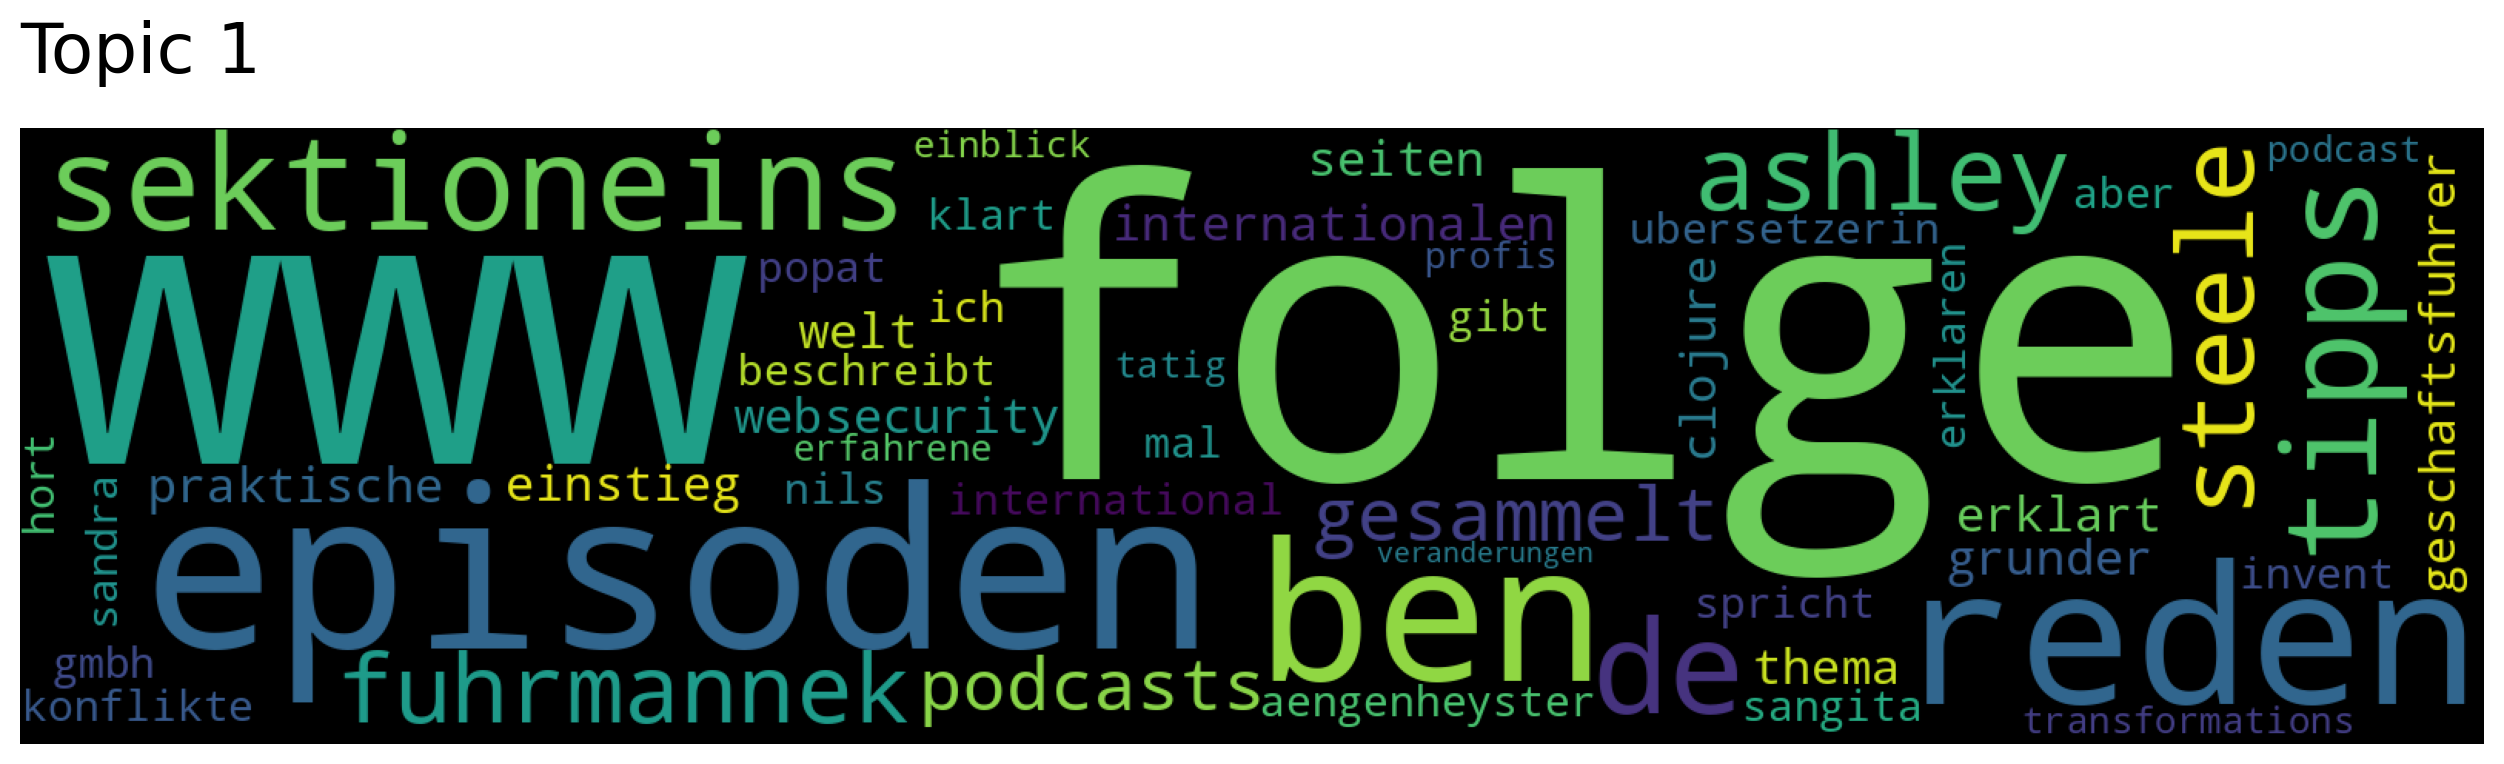

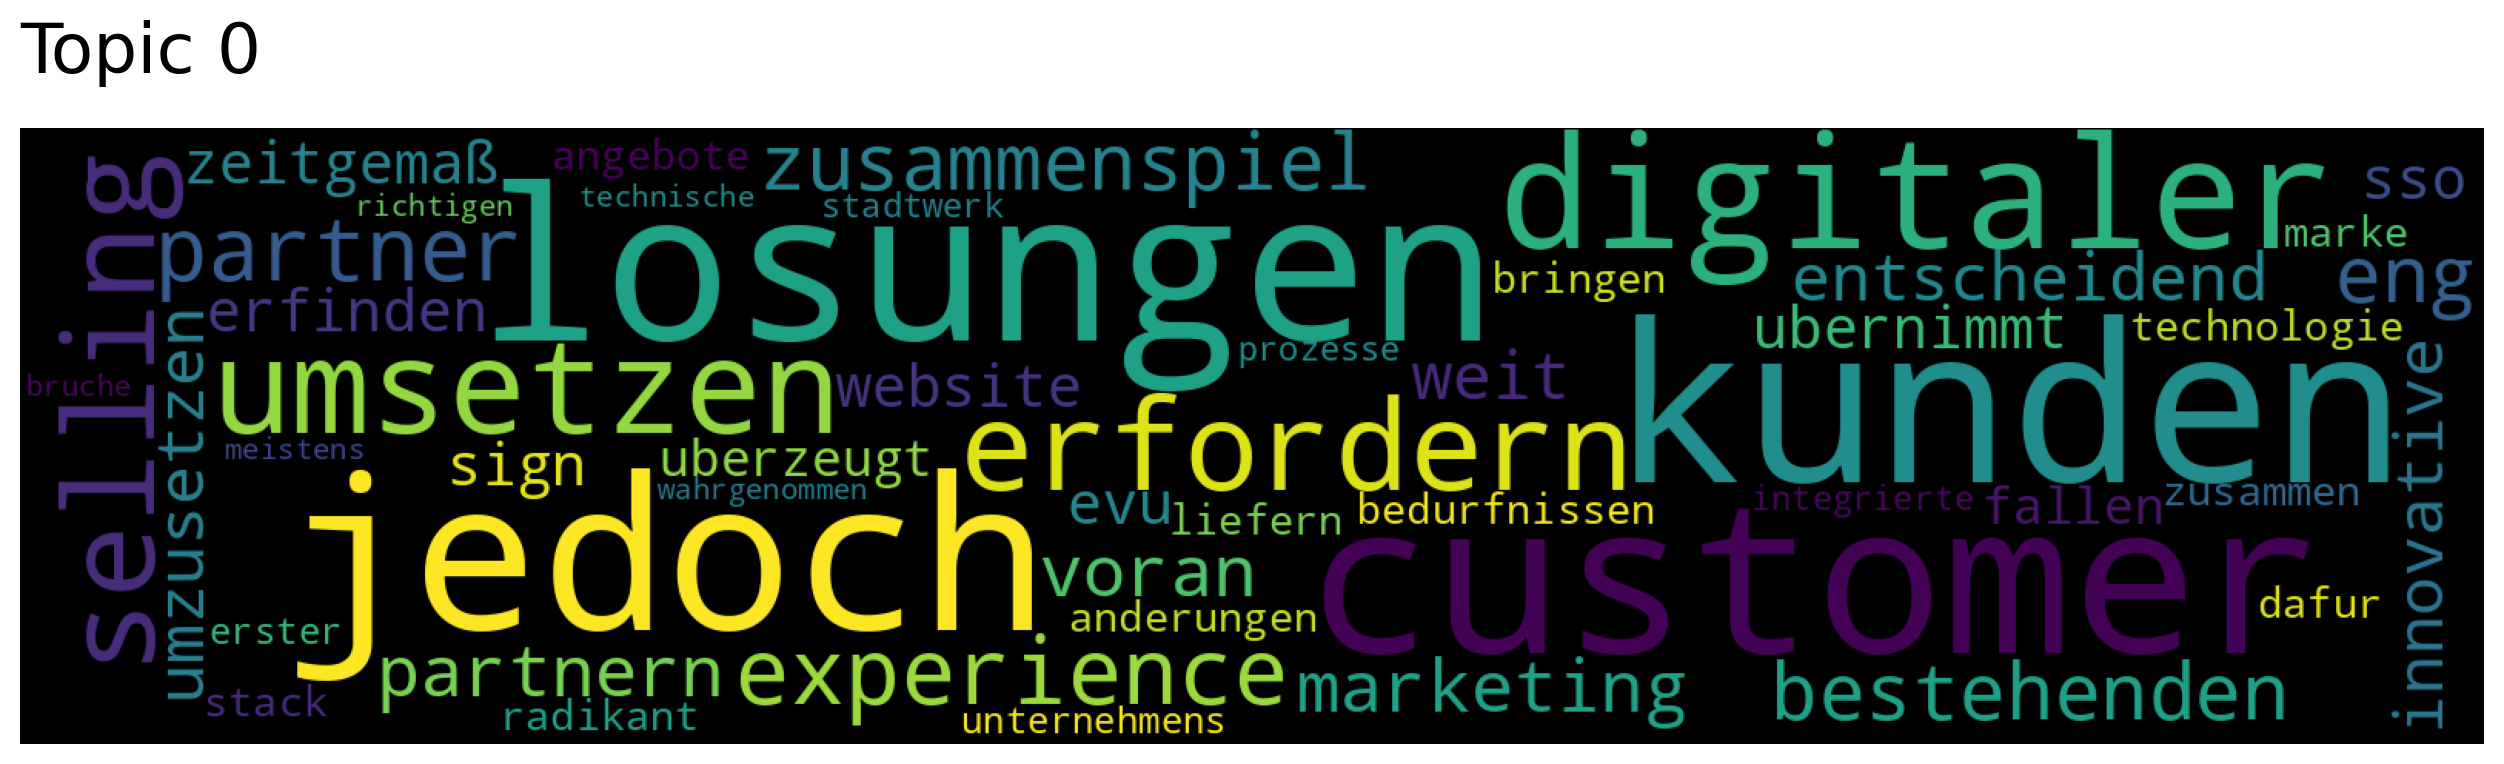

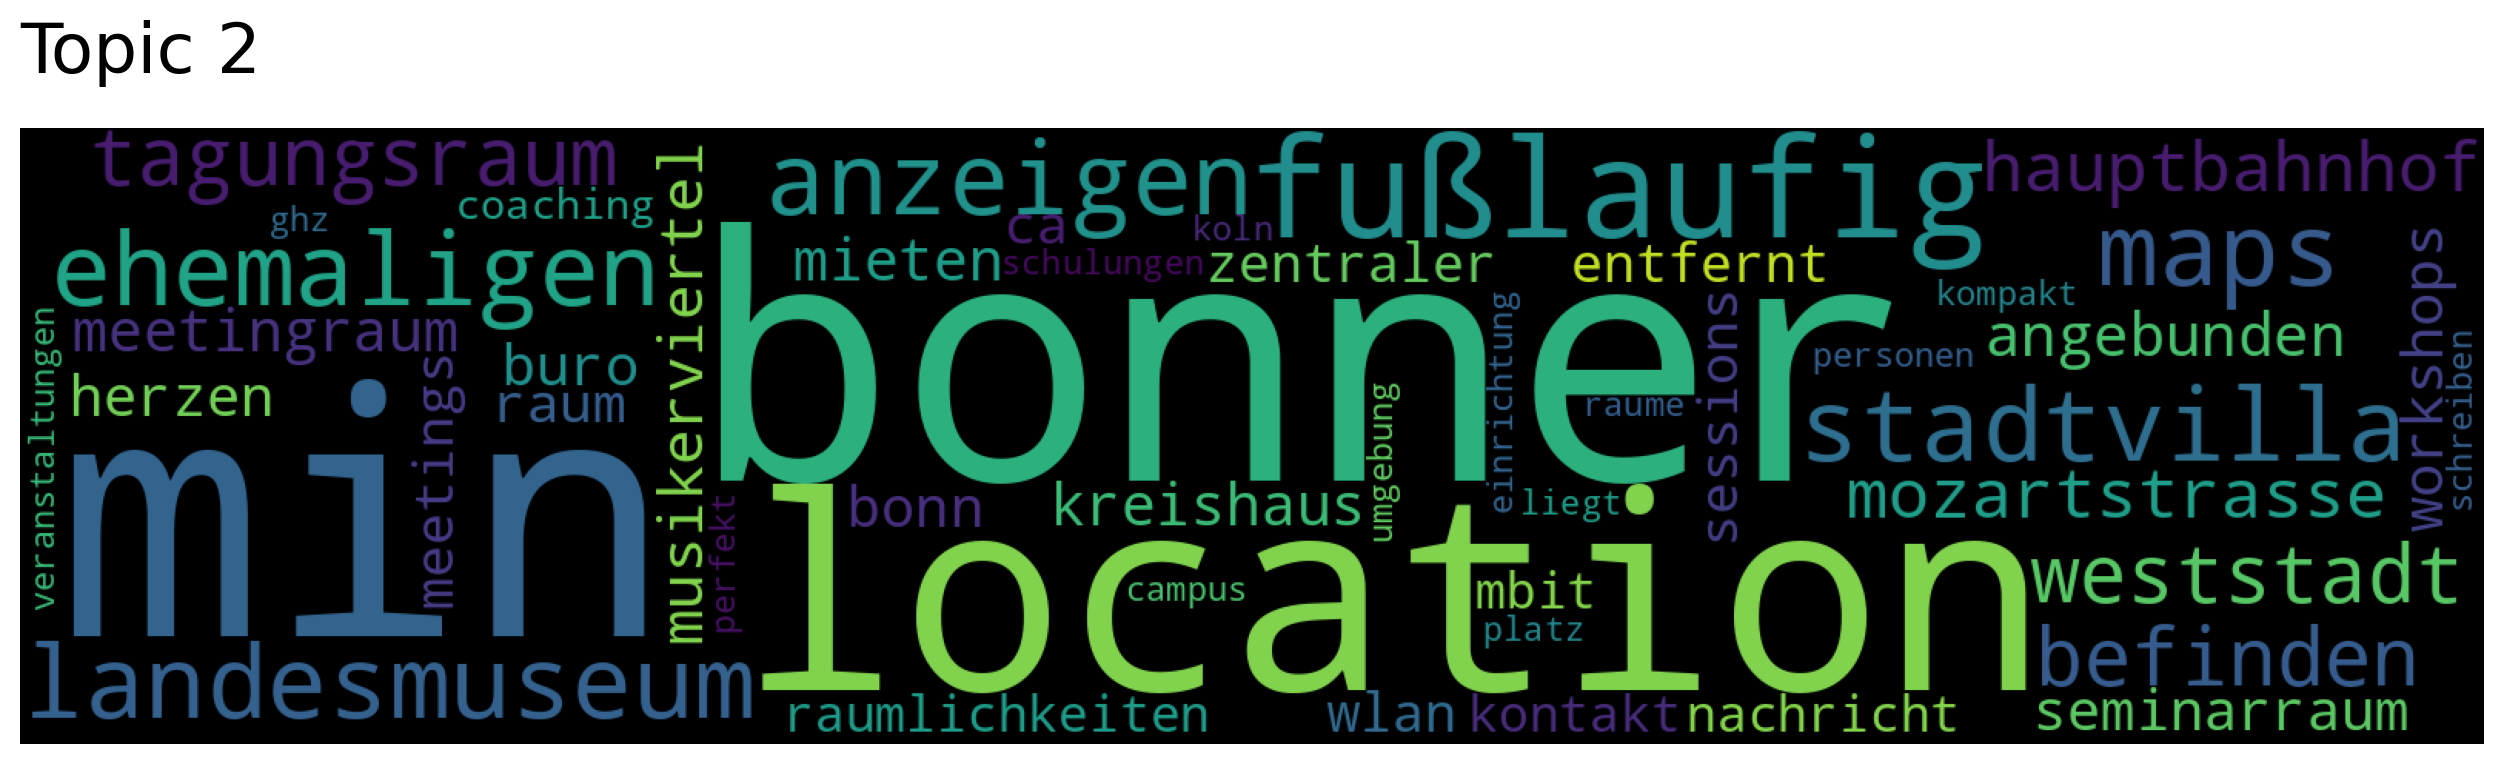

In [5]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw']

documents = list()
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as sections:
    for section in sections:
        documents.append(section['title'] + ' ' + section['heading'] + ' ' + section['content'])
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8, min_count=3)

print()
print(str(model.get_num_topics()) + ' topics discovered.')

print()
print('Top 3 topics returned for keyword search "kickstartDS":')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["kickstartDS"], num_topics=3)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 10 words by similarity to keyword "kickstartDS":')
words, word_scores = model.similar_words(keywords=["kickstartDS"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 10 sections for topic #1')
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

passages = []
with jsonlines.open('page_content.jsonl') as reader:
    for page in reader:
        #Add all paragraphs
        passages.extend(page['paragraphs'])

        #Only add the first paragraph
        #passages.append(page['paragraphs'][0])        

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np

# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
# This function will search all kickstartDS pages for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-5 lexical search (BM25) hits")
    for hit in bm25_hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-5 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))